In [2]:
# Imports and environment setup
import os
import random
from PIL import Image, ImageFile
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms, models
from torchvision.models import MobileNet_V2_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, classification_report
)

ImageFile.LOAD_TRUNCATED_IMAGES = True


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():

    # GPU info
    gpu_name = torch.cuda.get_device_name(0)
    props = torch.cuda.get_device_properties(0)
    total_mem_gb = props.total_memory / (1024**3)

    print(f"GPU: {gpu_name}")
    print(f"Total memory: {total_mem_gb:.1f} GB")
    print(f"SM count: {props.multi_processor_count}")
    print(f"Compute Capability (SM): {props.major}.{props.minor}")

    # ================================
    #  PyTorch optimization
    # ================================

    # 1. TF32 acceleration
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # 2. cuDNN optimization (choose the fastest kernel)
    torch.backends.cudnn.benchmark = True

else:
    print("Not CUDA compatible, CPU will be used.")


Device: cuda
GPU: NVIDIA GeForce RTX 5050 Laptop GPU
Total memory: 8.0 GB
SM count: 20
Compute Capability (SM): 12.0


In [3]:
# Dataset: Kaggle fruit detection dataset
# The dataset contains annotations (_annotations.csv), here we classify pictures so that
# a picture's label will be its most frequently occuring object class.

class FruitsFromAnnotations(Dataset):
    def __init__(self, images_dir: str, annotations_csv: str, transform=None):
        self.images_dir = images_dir
        self.annotations_csv = annotations_csv
        self.transform = transform

        # Reading annotations
        df = pd.read_csv(annotations_csv)
        # Choose the most frequent class for each image (filename)
        agg = (
            df.groupby('filename')['class']
              .agg(lambda s: s.value_counts().index[0])
              .reset_index()
        )

        # Gather class names and their indices alphabetically
        classes = sorted(agg['class'].unique().tolist())
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}

        # List of (image path, class index) tuples
        self.samples = []
        for _, row in agg.iterrows():
            img_path = os.path.join(images_dir, row['filename'])
            if os.path.exists(img_path):
                self.samples.append((img_path, self.class_to_idx[row['class']]))

        print(f"Loaded samples: {len(self.samples)} | Classes: {len(self.class_to_idx)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [4]:
# Transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
# Datasets, dataloaders
ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), '.')) if '__file__' in globals() else os.getcwd()
train_images = os.path.join(ROOT, 'archive', 'train')
valid_images = os.path.join(ROOT, 'archive', 'valid')
test_images = os.path.join(ROOT, 'archive', 'test')

train_csv = os.path.join(train_images, '_annotations.csv')
valid_csv = os.path.join(valid_images, '_annotations.csv')
test_csv = os.path.join(test_images, '_annotations.csv') if os.path.exists(os.path.join(test_images, '_annotations.csv')) else None

train_ds = FruitsFromAnnotations(train_images, train_csv, transform=transform_train)
valid_ds = FruitsFromAnnotations(valid_images, valid_csv, transform=transform_eval)

num_classes = len(train_ds.class_to_idx)
assert num_classes == len(valid_ds.class_to_idx), "Train and valid class suite differs."

batch_size = 64
pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin)

print(f"Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")


Loaded samples: 10848 | Classes: 15
Loaded samples: 600 | Classes: 15
Train batches: 170, Valid batches: 10


In [7]:
# Set up model (MobileNetV2, pretrained)
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [8]:
# Training loop
num_epochs = 6
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

all_valid_preds = []
all_valid_labels = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  Train batch {batch_idx+1}/{len(train_loader)} | loss={loss.item():.4f}")

    epoch_train_loss = running_loss / max(1, len(train_loader))
    epoch_train_acc = 100.0 * running_correct / max(1, running_total)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Eval
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    epoch_preds, epoch_labels = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            v_loss += loss.item()
            preds = outputs.argmax(dim=1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)
            epoch_preds.extend(preds.cpu().numpy().tolist())
            epoch_labels.extend(labels.cpu().numpy().tolist())

    epoch_valid_loss = v_loss / max(1, len(valid_loader))
    epoch_valid_acc = 100.0 * v_correct / max(1, v_total)
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    all_valid_preds = epoch_preds  # Epoch results
    all_valid_labels = epoch_labels

    print(f"Epoch ended | train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.2f}% | "
          f"valid_loss={epoch_valid_loss:.4f}, valid_acc={epoch_valid_acc:.2f}%")


Epoch 1/6
  Train batch 10/170 | loss=2.5749
  Train batch 20/170 | loss=2.4217
  Train batch 30/170 | loss=2.3575
  Train batch 40/170 | loss=2.3215
  Train batch 50/170 | loss=2.3673
  Train batch 60/170 | loss=2.2077
  Train batch 70/170 | loss=2.0068
  Train batch 80/170 | loss=2.1122
  Train batch 90/170 | loss=1.9709
  Train batch 100/170 | loss=1.9516
  Train batch 110/170 | loss=2.3516
  Train batch 120/170 | loss=2.0590
  Train batch 130/170 | loss=2.1010
  Train batch 140/170 | loss=2.0192
  Train batch 150/170 | loss=1.8681
  Train batch 160/170 | loss=1.8870
  Train batch 170/170 | loss=1.7510
Epoch ended | train_loss=2.1630, train_acc=35.25% | valid_loss=1.5029, valid_acc=56.67%
Epoch 2/6
  Train batch 10/170 | loss=1.5314
  Train batch 20/170 | loss=1.7188
  Train batch 30/170 | loss=1.5954
  Train batch 40/170 | loss=1.6383
  Train batch 50/170 | loss=1.6515
  Train batch 60/170 | loss=1.5269
  Train batch 70/170 | loss=1.6575
  Train batch 80/170 | loss=1.3986
  Train b

Learning curves saved: learning_curves.png


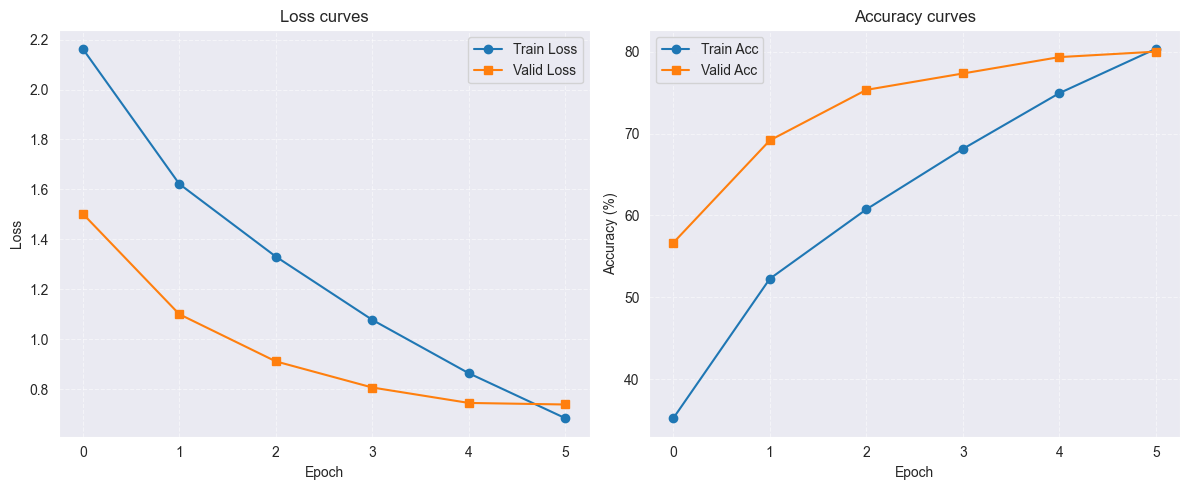

In [9]:
# Visualizing learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(valid_losses, marker='s', label='Valid Loss')
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1,2,2)
plt.plot(train_accs, marker='o', label='Train Acc')
plt.plot(valid_accs, marker='s', label='Valid Acc')
plt.title('Accuracy curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
try:
    os.makedirs('GeneratedPhotos', exist_ok=True)
    plt.savefig('./GeneratedPhotos/learning_curves.png', dpi=150)
    print("Learning curves saved: learning_curves.png")
except Exception as e:
    print(f"Saving picture failed: {e}")
plt.show()


Confusion matrix (counts) saved: confusion_matrix_counts.png


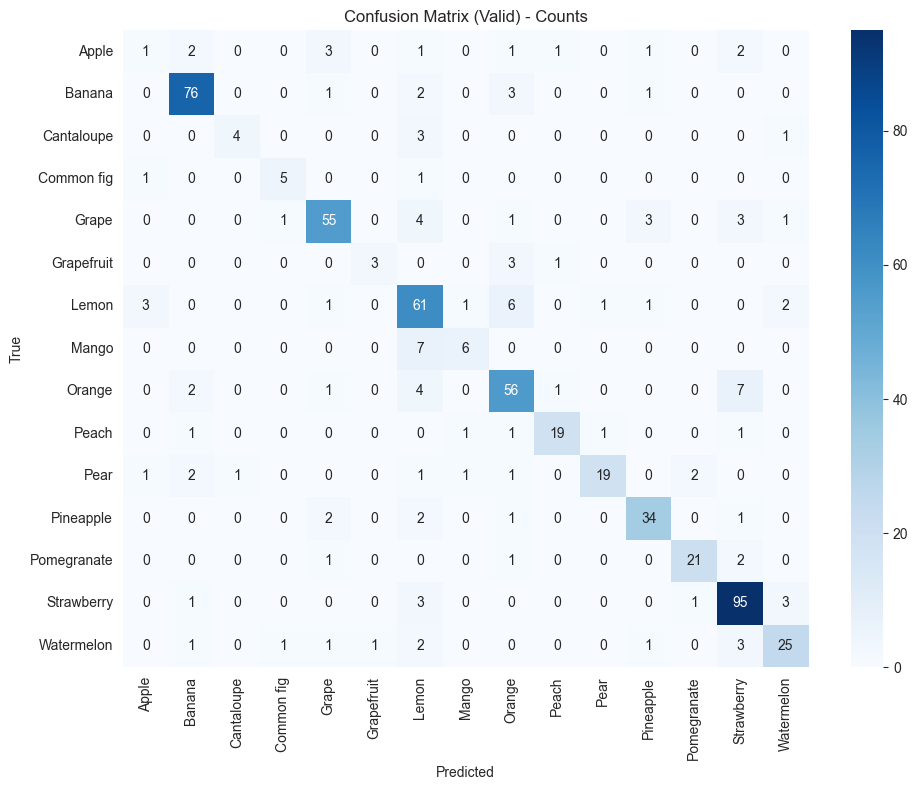

Confusion matrix (normalized) saved: confusion_matrix_normalized.png


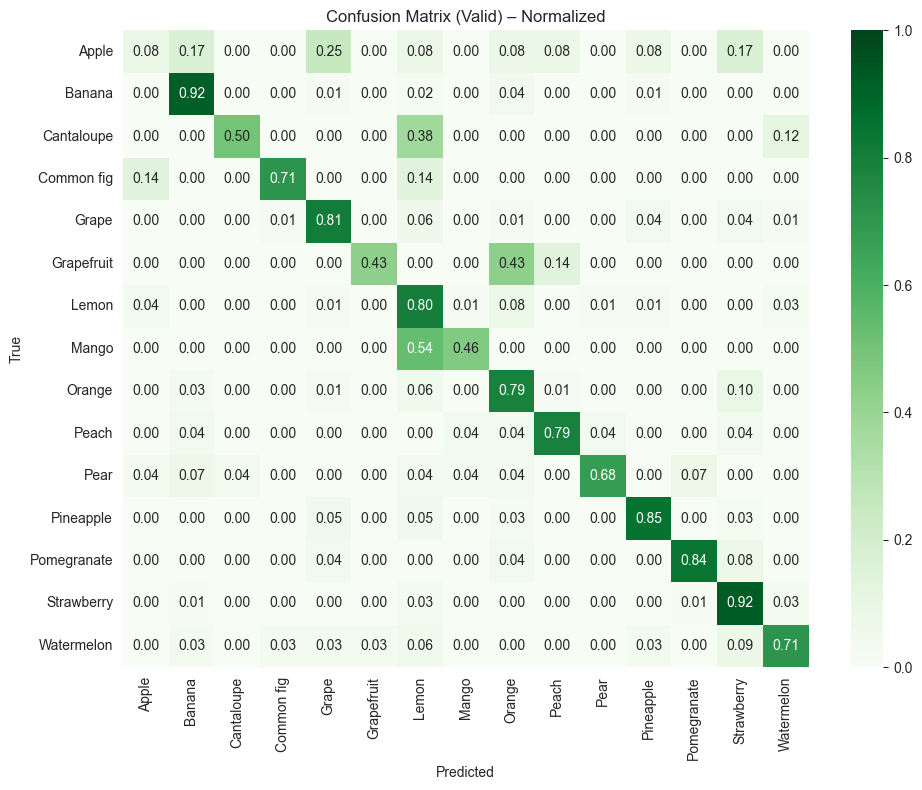

Precision (macro): 0.7568
Recall (macro):    0.6867
F1-score (macro):  0.7124

Detailed report:

              precision    recall  f1-score   support

       Apple       0.17      0.08      0.11        12
      Banana       0.89      0.92      0.90        83
  Cantaloupe       0.80      0.50      0.62         8
  Common fig       0.71      0.71      0.71         7
       Grape       0.85      0.81      0.83        68
  Grapefruit       0.75      0.43      0.55         7
       Lemon       0.67      0.80      0.73        76
       Mango       0.67      0.46      0.55        13
      Orange       0.76      0.79      0.77        71
       Peach       0.86      0.79      0.83        24
        Pear       0.90      0.68      0.78        28
   Pineapple       0.83      0.85      0.84        40
 Pomegranate       0.88      0.84      0.86        25
  Strawberry       0.83      0.92      0.88       103
  Watermelon       0.78      0.71      0.75        35

    accuracy                         

In [10]:
# Evaluation: Confusion Matrix, Precision, Recall, F1
class_names = [train_ds.idx_to_class[i] for i in range(num_classes)]

assert len(all_valid_labels) == len(all_valid_preds), "The length of labels and predictions must be equal."
if len(all_valid_labels) == 0:
    print("Warning: No valid samples for evaluation.")
else:
    cm = confusion_matrix(all_valid_labels, all_valid_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Valid) - Counts')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    try:
        plt.savefig('./GeneratedPhotos/confusion_matrix_counts.png', dpi=150)
        print("Confusion matrix (counts) saved: confusion_matrix_counts.png")
    except Exception as e:
        print(f"CM save failed: {e}")
    plt.show()

    # Normalized CM (row by row)
    cm_norm = confusion_matrix(all_valid_labels, all_valid_preds, labels=list(range(num_classes)), normalize='true')
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    plt.title('Confusion Matrix (Valid) – Normalized')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    try:
        plt.savefig('./GeneratedPhotos/confusion_matrix_normalized.png', dpi=150)
        print("Confusion matrix (normalized) saved: confusion_matrix_normalized.png")
    except Exception as e:
        print(f"CM norm save failed: {e}")
    plt.show()

if len(all_valid_labels) > 0:
    prec = precision_score(all_valid_labels, all_valid_preds, average='macro', zero_division=0)
    rec = recall_score(all_valid_labels, all_valid_preds, average='macro', zero_division=0)
    f1 = f1_score(all_valid_labels, all_valid_preds, average='macro', zero_division=0)
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro):    {rec:.4f}")
    print(f"F1-score (macro):  {f1:.4f}")

    print("\nDetailed report:\n")
    print(classification_report(all_valid_labels, all_valid_preds, target_names=class_names, zero_division=0))
else:
    print("The metrics cannot be calculated because there are no valid predictions.")



Samples saved: val_samples.png


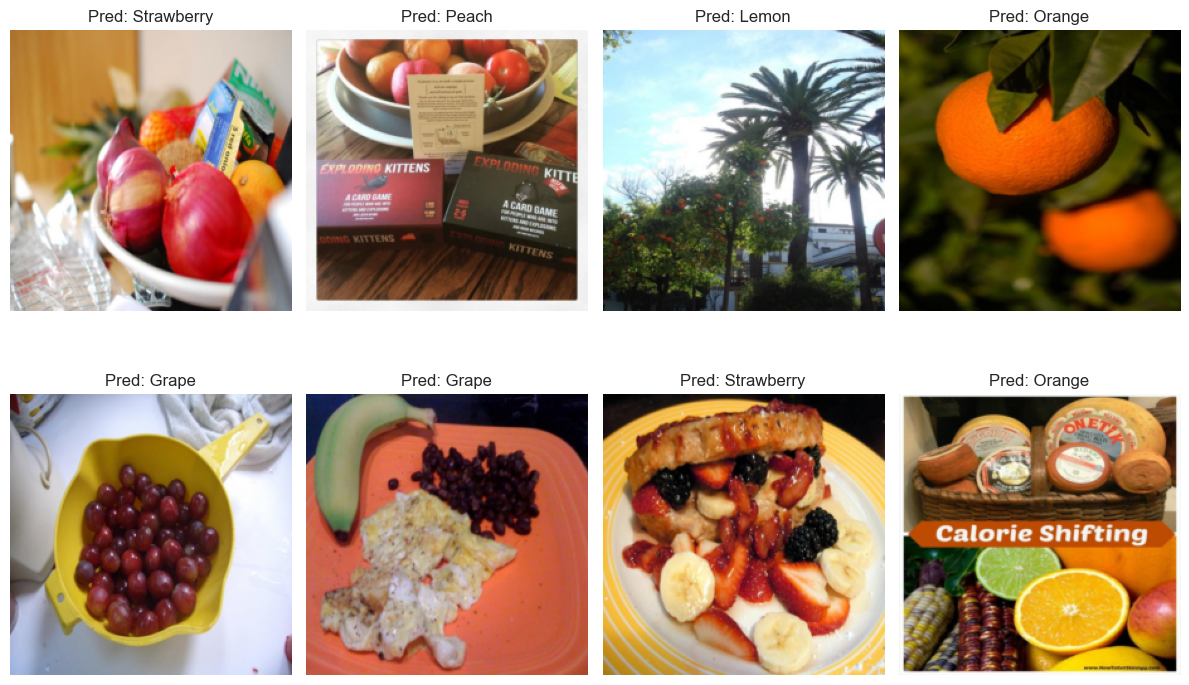

In [11]:
# Some valid samples visualized with predictions
def imshow_tensor(img_tensor):
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(img_tensor.cpu()).clamp(0,1)
    npimg = img.permute(1,2,0).numpy()
    plt.imshow(npimg)
    plt.axis('off')

model.eval()
images_shown = 0
plt.figure(figsize=(12,8))
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        for i in range(min(8, images.size(0))):
            plt.subplot(2,4,images_shown+1)
            imshow_tensor(images[i])
            plt.title(f"Pred: {class_names[preds[i].item()]}")
            images_shown += 1
            if images_shown == 8:
                break
        break
plt.tight_layout()
try:
    plt.savefig('./GeneratedPhotos/val_samples.png', dpi=150)
    print("Samples saved: val_samples.png")
except Exception as e:
    print(f"Sample save failed: {e}")
plt.show()
